In [8]:
from cellworld import *
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm.notebook import tqdm
from ipywidgets import *
import pickle

# ITOR
## 1. Tile the environment
This will allow faster computation of visibility

<IPython.core.display.Javascript object>


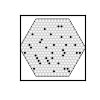

<IPython.core.display.Javascript object>


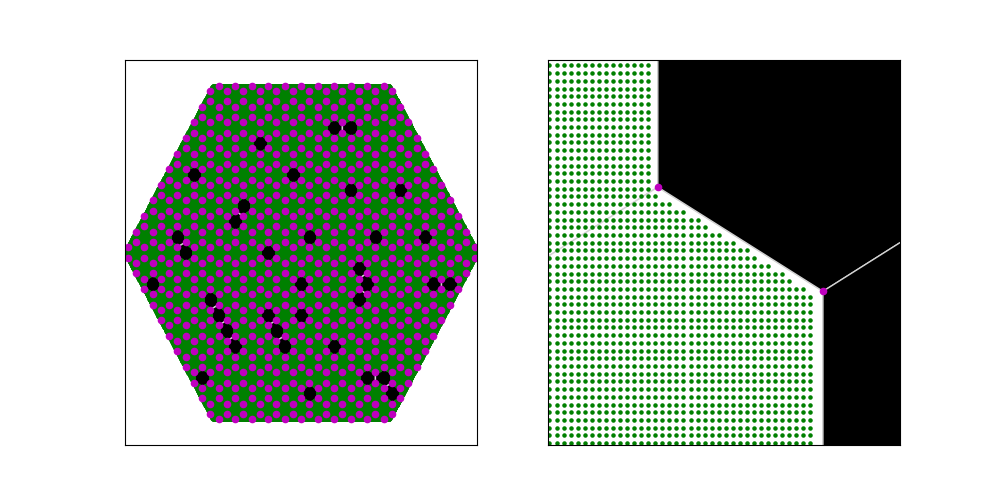

<IPython.core.display.Javascript object>


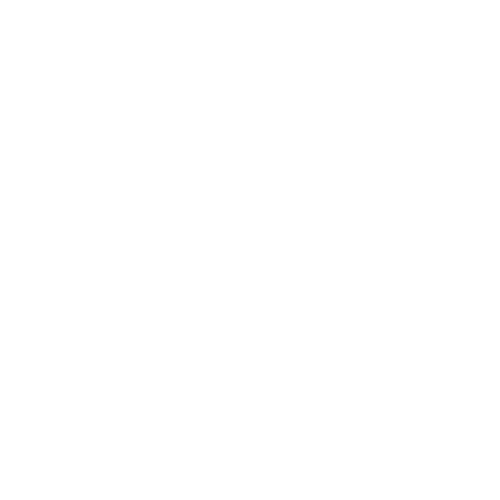

<IPython.core.display.Javascript object>


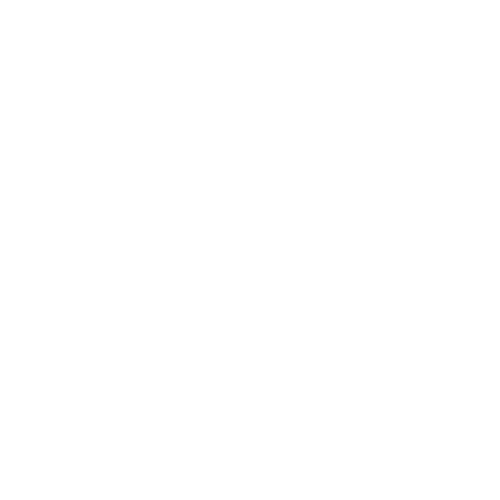

[<Figure size 1000x500 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)]

In [23]:
from _src.visibility import *
e = Experiment.load_from_file('./_data/MICE_20220608_1557_DMM3_21_05_SR5_experiment.json')
vis,w = get_vis(e)
sparse_arr = get_vertices(e)
n = 1000
pts = get_tiles(n,e)
plot_tiles(pts,sparse_arr,e)

## 2. Compute/Load visibility graph

In [26]:
filename = f'visibility-{e.occlusions}-{n}.pkl'
filepath = f'./_data/{filename}'

if not glob.glob(filepath):
    print(f'Computing visibility graph using {n}x{n} resolution...')
    V,A = compute_visibility(pts,sparse_arr,vis)
    print(f'Saving visibility graph {filename}...')
    pickle.dump([A,V,pts,sparse_arr],open(filepath,'wb'))
    
else:
    print(f'Loading visibility graph {filename}...')
    [A,V,pts,sparse_arr] = pickle.load(open(filepath,'rb'))
    
vis_graph = {'V':V,'A':A,'src':pts,'dst':sparse_arr}

Loading visibility graph visibility-21_05-1000.pkl...


## 3. ITOR Simulator
Plot single

310.0


<IPython.core.display.Javascript object>


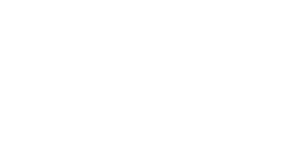

In [27]:
from _src.pose import *
from _src.itor import *

def plot_itor(I,vis_graph,w,ax,fig):
    # plot the world
    d = Display(w, fig_size=(7,9), padding=0, cell_edge_color="lightgrey",ax=ax,fig=fig)
    # plot the pose used to compute ITOR
    ppts = np.vstack(I['pose_points'])
    h0 = ax.arrow(ppts[I['head_idx'],0][0],ppts[I['head_idx'],1][0],
                  np.cos(np.deg2rad(90-I['head_angle']))*.025,
                  np.sin(np.deg2rad(90-I['head_angle']))*.025,head_width=.01,zorder=4)
    h1, = ax.plot(ppts[:,0],ppts[:,1],'grey',marker='.')
    h2, = ax.plot(ppts[I['head_idx'],0],
                  ppts[I['head_idx'],1],'m',marker='*',zorder=3)
    h3, = ax.plot(ppts[I['body_idx'],0],
                  ppts[I['body_idx'],1],'c',marker='*',zorder=3)
    h4, = ax.plot(vis_graph['dst'][I['vis_omni'],0],
                  vis_graph['dst'][I['vis_omni'],1],'g.',alpha=0.25)
    h5, = ax.plot(vis_graph['dst'][I['vis_head'],0],
                  vis_graph['dst'][I['vis_head'],1],'g.')
    h6, = ax.plot(vis_graph['dst'][I['vis_body'],0],
                  vis_graph['dst'][I['vis_body'],1],'ro',fillstyle='none')
    h7 = ax.text(0.02,0.1,f'ITOR={np.round(I["ITOR"],3)}')
    
    return h0,h1,h2,h3,h4,h5,h6,h7

def update_plot_itor(I,vis_graph):
    # get pose
    ppts = np.vstack(I['pose_points'])
    # plot
    global h0
    h0.remove()
    h0 = ax.arrow(ppts[I['head_idx'],0][0],ppts[I['head_idx'],1][0],
                  np.cos(np.deg2rad(90-I['head_angle']))*.025,
                  np.sin(np.deg2rad(90-I['head_angle']))*.025,head_width=.01,zorder=4)
    h1.set_xdata(ppts[:,0])
    h1.set_ydata(ppts[:,1])
    h2.set_xdata(ppts[I['head_idx'],0])
    h2.set_ydata(ppts[I['head_idx'],1])
    h3.set_xdata(ppts[I['body_idx'],0])
    h3.set_ydata(ppts[I['body_idx'],1])
    h4.set_xdata(vis_graph['dst'][I['vis_omni'],0])
    h4.set_ydata(vis_graph['dst'][I['vis_omni'],1])
    h5.set_xdata(vis_graph['dst'][I['vis_head'],0])
    h5.set_ydata(vis_graph['dst'][I['vis_head'],1])
    h6.set_xdata(vis_graph['dst'][I['vis_body'],0])
    h6.set_ydata(vis_graph['dst'][I['vis_body'],1])
    h7.set_text(f'ITOR={np.round(I["ITOR"],3)}')
    fig.canvas.draw()
    fig.canvas.draw_idle()
                      
def update_sim_pose(head_x=0.55,head_y=0.12,body_angle=180,head_angle=45,fov=np.rad2deg(1.74533)):
    pose = {'head_base':[head_x,head_y],
            'body_mid':[head_x+np.cos(np.deg2rad(body_angle))*0.03,
                        head_y+np.sin(np.deg2rad(body_angle))*0.03]}
    return pose,head_angle,fov

def update_sim(head_angle = 45, body_angle=180, head_x = 0.55, head_y = 0.12, fov = 310.0/2):
    # body update
    pose,head_angle,_ = update_sim_pose(head_x,head_y,body_angle,head_angle)

    # compute ITOR
    I = compute_itor(pose,head_angle,vis_graph,fov=fov)
    
    # update the plot
    update_plot_itor(I,vis_graph)

# body update
# fov=np.rad2deg(1.74533)
fov = 310.0
pose,head_angle,fov = update_sim_pose(fov=fov)
print(fov)

# compute ITOR
I = compute_itor(pose,head_angle,vis_graph,fov=fov)

# plot
fig,ax = plt.subplots(1,1,figsize=(7,5))
h0,h1,h2,h3,h4,h5,h6,h7 = plot_itor(I,vis_graph,w,ax,fig)

Interactive simulation

<IPython.core.display.Javascript object>


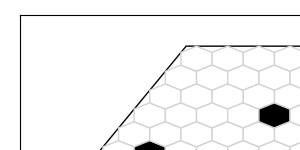

interactive(children=(IntSlider(value=45, description='head_angle', max=180, min=-180), IntSlider(value=180, d…

In [28]:
%matplotlib notebook

# settings
full_fov = np.rad2deg(1.74533)
binocular_fov = np.rad2deg(0.349066)

# body update
pose,head_angle,fov = update_sim_pose(fov = 310.0/2)

# compute ITOR
I = compute_itor(pose,head_angle,vis_graph,fov=fov)

# plot
fig,ax = plt.subplots(1,1,figsize=(7,5))
h0,h1,h2,h3,h4,h5,h6,h7 = plot_itor(I,vis_graph,w,ax,fig)


interact(update_sim,head_angle=widgets.IntSlider(min=-180, max=180, step=1, value=45),
        body_angle=widgets.IntSlider(min=0, max=360, step=1, value=180),
        head_x=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.55),
        head_y=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.12),
        fov=widgets.RadioButtons(options=[np.rad2deg(1.74533)+50,np.rad2deg(1.74533),np.rad2deg(0.349066)],description='FOV',disabled=False));
